# Create mask (inc vs dec) based on ML HYCOM data, classify data in increasing vs decreasing, calculate composites and make maps


In [15]:
import xarray as xr
import csv
import pandas as pd
import pickle
import numpy as np
import os
from datetime import date, timedelta, datetime
import sys
import matplotlib.pyplot as plt
import netCDF4 as nc4
import glob
import os.path
import webbrowser
import time
import gsw
import scipy.io as scipy
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib as mpl
from FUNCTIONS_HYCOM import set_regions, set_regions_tags, find_timedelta64_index, \
create_composite, name_composite, below_above_MLD, plot_simple_pcolor, set_regions_offset, draw_box, \
save_3dvars_as_nc4, save_2dvars_as_nc4, save_1dvars_as_nc4, \
set_cmap, set_clim_plots, set_clim_plots_std, set_clim_plots_diff, set_clim_plots_std_diff, \
function_map_2D_hist, function_plots, function_single_panels_plots
import pickle as pkl
from holteandtalley import HolteAndTalley
import subprocess

In [16]:
# Open netcdf with both HYCOM and forcing data from all events across all regions, at hourly resolution
combined_regions = xr.open_dataset('/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/scripf_for_downloading_forcing_files_CURC/combined_regions_with_rel_hum.nc4')


In [17]:
# Needed for mask calculation
min_levels_below_ML = 5 # minimum number of levels below MLD for classification to be acceptable

# REMOVE i_time if it's the same as index_time_start 
i_time = int((np.abs(combined_regions.delta_time - int(-2 * 24 * 60 * 60 * 1E9))).argmin()) # time index where to perform the classification (-2 days)

# Needed for composite calculation & plots
index_time_start = int((np.abs(combined_regions.delta_time - int(-2 * 24 * 60 * 60 * 1E9))).argmin()) # 2 days prior
index_time_end = int((np.abs(combined_regions.delta_time - int(14 * 24 * 60 * 60 * 1E9))).argmin()) # 14 days after

# Needed for composite plots
offset_lon = 20
timesteps_before = 2*24 # 2 days prior
timesteps_after = 14*24 # 14 days after
time_plot = np.arange(-timesteps_before,timesteps_after+1,1) * 1/24


In [18]:
# Vertical structure of absolute salinity, to use for classification
data = combined_regions.salinity_abs
# MLD to use for classification
MLD = combined_regions.salinityMLD_abs

In [19]:
# Calculate mask increasing/decreasing (based on MLD salinity)
# Goal: have a numpy array with True/False for increasing/decreasing, with one value for each event

# Initialize list for mask
mask_incr = []
mask_decr = []

for i_event in np.arange(data.shape[0]): # loop across events
    
    # Find depth index to insert ML
    i_ML_sorted_depth = np.searchsorted(data[i_event].depth.values, MLD[i_event][i_time])
    depth_new = np.insert(data[i_event].depth.values, i_ML_sorted_depth, MLD[i_event][i_time])

    if np.shape(depth_new)[0] - i_ML_sorted_depth > 5: # proceed only if more than 5 layers below the ML exist
        
        # MIXED LAYER
        # Create new depth axis which includes MLD
        depth_new = np.insert(data[i_event].depth.values, i_ML_sorted_depth, MLD[i_event][i_time])
        # Calculate salinity at MLD via interpolation
        salinity_abs_upper = data[i_event][i_time].interp(depth=depth_new)

        # Calculate weighted average of salinity within the ML (from surface to MLD)
        # First, need to calculate dz (depth of each layer associated with a salinity value)
        depth_new_upper = np.insert(depth_new, i_ML_sorted_depth, MLD[i_event][i_time]) # add another MLD value next to the other one
        depth_new_upper = np.insert(depth_new_upper, 0, 0) # add another zero at the beginning of the depth

        dz = (depth_new_upper[2:i_ML_sorted_depth+3]-depth_new_upper[0:i_ML_sorted_depth+1])/2 # calculate dz as half of the difference between depth value above and below each depth
        MLS_abs_wgt = (np.sum(dz * salinity_abs_upper[0:i_ML_sorted_depth+1]))/np.sum(dz) # weighted average from surface to MLD

        # LAYER BELOW ML
        # Create new depth axis which includes meters_below_ML below MLD
        depth_new_lower = np.insert(depth_new, i_ML_sorted_depth, MLD[i_event][i_time]) # add another MLD value next to the other one
        depth_new_lower = np.insert(depth_new_lower, -1, depth_new[-1]) # add another 500 at the end of the depth

        dz = (depth_new_lower[i_ML_sorted_depth+2:]-depth_new_lower[i_ML_sorted_depth:-2])/2 # calculate dz as half of the difference between depth value above and below each depth
        salinity_abs_wgt_lower = (np.sum(dz * salinity_abs_upper[i_ML_sorted_depth:]))/np.sum(dz) # weighted average from MLD to bottom

        # Calculate difference between salinity in layer below ML and weighted average of salinity in the ML
        mean_salinity_diff_below = np.mean(salinity_abs_wgt_lower - MLS_abs_wgt)

        # If mean_salinity_diff_below > 0 --> increasing
        if mean_salinity_diff_below >= 0: 
            mask_incr.append(1)
            mask_decr.append(0)
        # If mean_salinity_diff_below < 0 --> decreasing
        elif mean_salinity_diff_below < 0: 
            mask_incr.append(0)
            mask_decr.append(1)                
        else: # Nans or other weird stuff
            mask_incr.append(0)
            mask_decr.append(0)   
    else: # if only less than 5 layers below the ML exist: both Falses
        mask_incr.append(0)
        mask_decr.append(0)     


In [20]:
# OLD MASK

# # Calculate mask increasing/decreasing (based on 2 days before the event)
# # Goal: have a numpy array with True/False for increasing/decreasing, with one value for each event

# # Initialize list for mask
# mask_incr = []
# mask_decr = []

# for i_event in np.arange(data.shape[0]): # loop across events
    
#     # MIXED LAYER
#     # Create new depth axis which includes MLD
#     i_ML_sorted_depth = np.searchsorted(data[i_event].depth.values, MLD[i_event][i_time])
#     depth_new_upper = np.insert(data[i_event].depth.values, i_ML_sorted_depth, MLD[i_event][i_time])
#     # Calculate salinity at MLD via interpolation
#     salinity_abs_upper = data[i_event][i_time].interp(depth=depth_new_upper)
    
#     # Calculate weighted average of salinity within the ML (from surface to MLD)
#     # First, need to calculate dz (depth of each layer associated with a salinity value)
#     depth_new_upper = np.insert(depth_new_upper, i_ML_sorted_depth, MLD[i_event][i_time]) # add another MLD value next to the other one
#     depth_new_upper = np.insert(depth_new_upper, 0, 0) # add another zero at the beginning of the depth

#     dz = (depth_new_upper[2:i_ML_sorted_depth+3]-depth_new_upper[0:i_ML_sorted_depth+1])/2 # calculate dz as half of the difference between depth value above and below each depth
# #     dz[-1] = (depth_new_upper[i_ML_sorted_depth+1]-depth_new_upper[i_ML_sorted_depth])/2
#     MLS_abs_wgt = (np.sum(dz * salinity_abs_upper[0:i_ML_sorted_depth+1]))/np.sum(dz) # weighted average from surface to MLD

#     # LAYER BELOW ML
#     # Create new depth axis which includes meters_below_ML below MLD
#     i_ML_below_sorted_depth = np.searchsorted(data[i_event].depth.values, MLD[i_event][i_time] + meters_below_ML)
#     depth_new_lower = np.insert(data[i_event].depth.values, i_ML_below_sorted_depth, MLD[i_event][i_time] + meters_below_ML)
#     # Calculate salinity at meters_below_ML below MLD via interpolation
#     salinity_abs_lower = data[i_event][i_time].interp(depth=depth_new_lower)
    
#     # Calculate difference between salinity in layer below ML and weighted average of salinity in the ML
#     mean_salinity_diff_below = np.mean(salinity_abs_lower - MLS_abs_wgt)

#     # If mean_salinity_diff_below > 0 --> increasing
#     if mean_salinity_diff_below >= 0: 
#         mask_incr.append(1)
#         mask_decr.append(0)
#     # If mean_salinity_diff_below < 0 --> decreasing
#     else: 
#         mask_incr.append(0)
#         mask_decr.append(1)                
 

In [21]:
# dz = (depth_new_upper[2:i_ML_sorted_depth+3]-depth_new_upper[0:i_ML_sorted_depth+1])/2 # calculate dz as half of the difference between depth value above and below each depth


In [22]:
# Change format to make it consistent with old version of the code
mask_incr = np.ravel(mask_incr).astype(bool)
mask_decr = np.ravel(mask_decr).astype(bool)

In [23]:
# List variable names
data = ['temperature_abs_all', 'salinity_abs_all', 'density_abs_all', \
        'temperature_abs_minus2_all', 'salinity_abs_minus2_all', 'density_abs_minus2_all', \
        'temperature_anom_minus2_all', 'salinity_anom_minus2_all', 'density_anom_minus2_all']

# Cases for selection
data_mask = ['mask_incr',
             'mask_decr']

In [24]:
# Extract variables from combined_regions
# Save only from -2 days to +14 days
temperature_abs_all = combined_regions.temperature_abs[:,index_time_start:index_time_end+1,:].values
salinity_abs_all =  combined_regions.salinity_abs[:,index_time_start:index_time_end+1,:].values
density_abs_all =  combined_regions.density_abs[:,index_time_start:index_time_end+1,:].values
temperature_abs_minus2_all =  combined_regions.temperature_abs_minus2[:,index_time_start:index_time_end+1,:].values
salinity_abs_minus2_all =  combined_regions.salinity_abs_minus2[:,index_time_start:index_time_end+1,:].values
density_abs_minus2_all =  combined_regions.density_abs_minus2[:,index_time_start:index_time_end+1,:].values
temperature_anom_minus2_all =  combined_regions.temperature_anom_minus2[:,index_time_start:index_time_end+1,:].values
salinity_anom_minus2_all = combined_regions.salinity_anom_minus2[:,index_time_start:index_time_end+1,:].values
density_anom_minus2_all = combined_regions.density_anom_minus2[:,index_time_start:index_time_end+1,:].values

longitudes_2d_map  = combined_regions.longitude.values
latitudes_2d_map  = combined_regions.latitude.values

In [25]:
# Compute composites
for idata in data:
    for imask in data_mask:
        bfr_d = eval(idata)
        # Swap axes to make consistent with older version (and functions below)
        bfr_d = np.swapaxes(bfr_d,0,2)
        bfr_d = np.swapaxes(bfr_d,0,1)
        
        print(idata)
        bfr_mask = eval(imask)
        print(imask)
        print('+++++++++++++++++++++++++++++++++')
        # Function that creates composites
        bfr = create_composite(bfr_d, bfr_mask, longitudes_2d_map, latitudes_2d_map)

        print('---------------------------------')
        #exec(name_composite(idata, imask) + '_filename = [file_name_all[i] for i in np.arange(len(file_name_all)) if bfr_mask[i]]')        
        exec(name_composite(idata, imask) + ' = bfr[0]')
        exec(name_composite(idata, imask) + '_std = bfr[1]')
        exec(name_composite(idata, imask) + '_std_error = bfr[2]')
        exec(name_composite(idata, imask) + '_num_composite = bfr[3]')
        exec(name_composite(idata, imask) + '_profiles = bfr[4]') # profiles that could be saved as .pkl for GOTM 1D model
        exec(name_composite(idata, imask) + '_long = bfr[5]') 
        exec(name_composite(idata, imask) + '_lat = bfr[6]')

temperature_abs_all
mask_incr
+++++++++++++++++++++++++++++++++
Number of events in this case =  716
---------------------------------
temperature_abs_all
mask_decr
+++++++++++++++++++++++++++++++++
Number of events in this case =  511
---------------------------------
salinity_abs_all
mask_incr
+++++++++++++++++++++++++++++++++
Number of events in this case =  716
---------------------------------
salinity_abs_all
mask_decr
+++++++++++++++++++++++++++++++++
Number of events in this case =  511
---------------------------------
density_abs_all
mask_incr
+++++++++++++++++++++++++++++++++
Number of events in this case =  716
---------------------------------
density_abs_all
mask_decr
+++++++++++++++++++++++++++++++++
Number of events in this case =  511
---------------------------------
temperature_abs_minus2_all
mask_incr
+++++++++++++++++++++++++++++++++
Number of events in this case =  716
---------------------------------
temperature_abs_minus2_all
mask_decr
+++++++++++++++++++++++++

In [12]:
# Variables list for plots
var_list = ['salinity', 'temperature', 'density']

# Type list for plots
type_list = ['abs_minus2', 'anom_minus2']

# Cases list for plots
case_list = ['mask_incr', 'mask_decr']

# Hatch list for plots - standard deviation or standard error
type_hatch_list = ['_std_error']

units_list = ['Salinity change (psu)', 'Temperature change (°C)', 'Pot. density change (kg/m$^3$)']


max number per bin: 6.0
total number: 713.0


/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:454: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = a2.pcolor(data_xaxis, data_yaxis, data.transpose(), vmin=data_vmin, vmax=data_vmax, cmap=cmap)
/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:477: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = a3.pcolor(data_xaxis, data_yaxis, data_ihatch.transpose(), vmin=std_vmin, vmax=std_vmax, 

/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:500: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = a2.pcolor(data_xaxis, data_yaxis, data.transpose(), vmin=data_vmin, vmax=data_vmax, cmap=cmap_bfr)


max number per bin: 4.0
total number: 502.0


/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:454: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = a2.pcolor(data_xaxis, data_yaxis, data.transpose(), vmin=data_vmin, vmax=data_vmax, cmap=cmap)
/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:477: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im3 = a3.pcolor(data_xaxis, data_yaxis, data_ihatch.transpose(), vmin=std_vmin, vmax=std_vmax, 

/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/FUNCTIONS_HYCOM.py:500: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = a2.pcolor(data_xaxis, data_yaxis, data.transpose(), vmin=data_vmin, vmax=data_vmax, cmap=cmap_bfr)


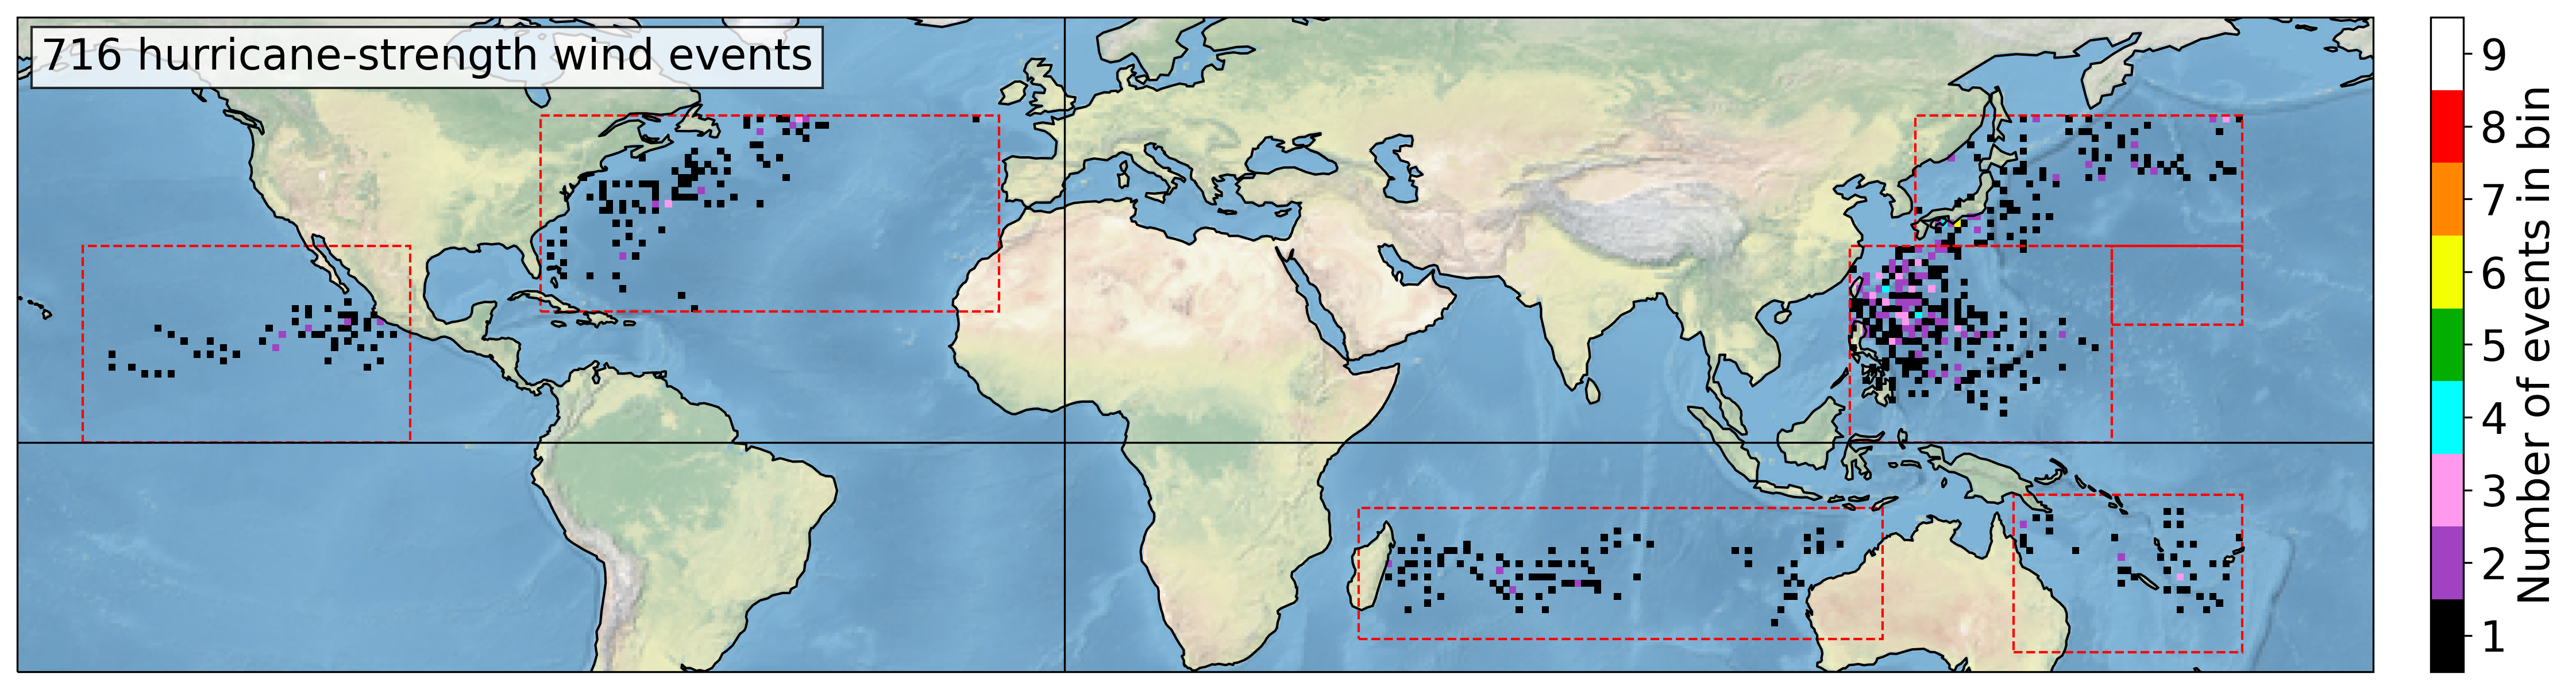

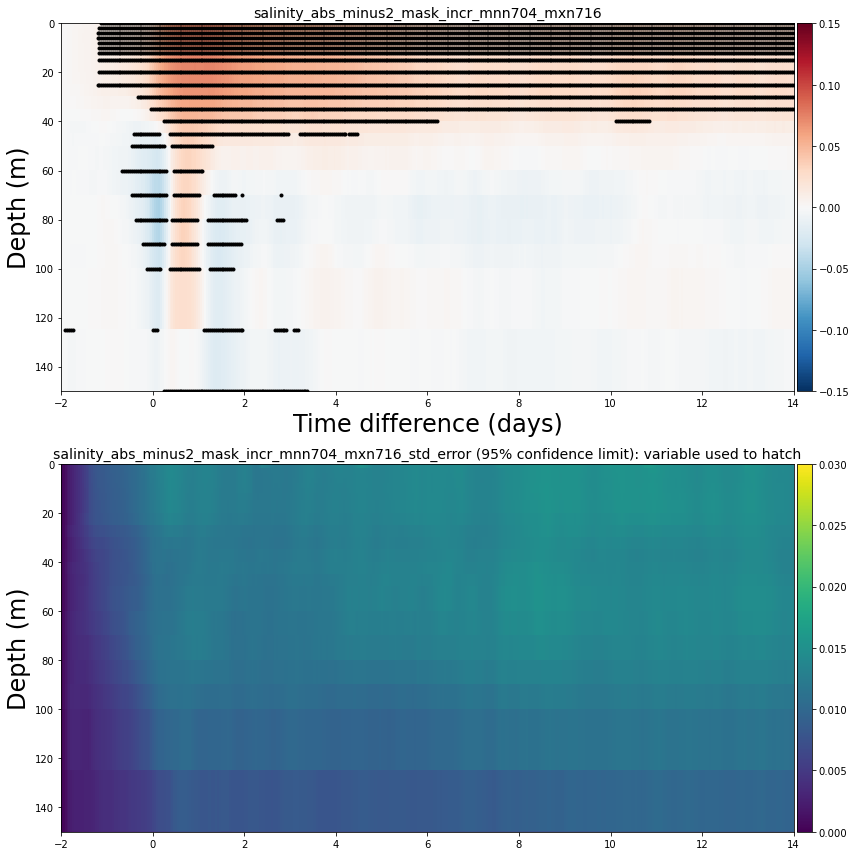

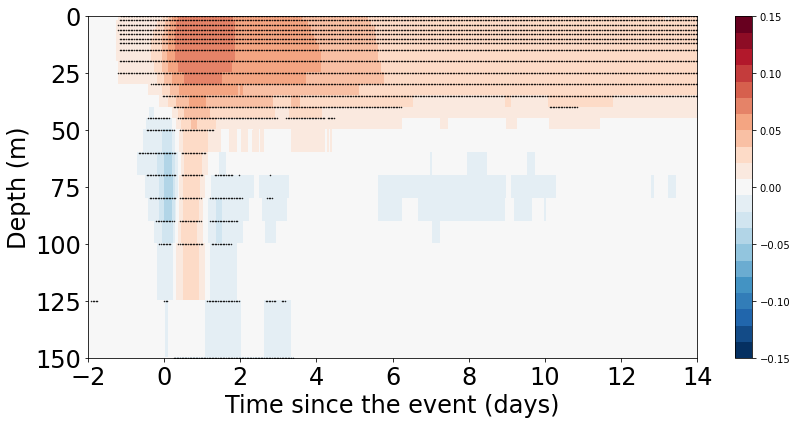

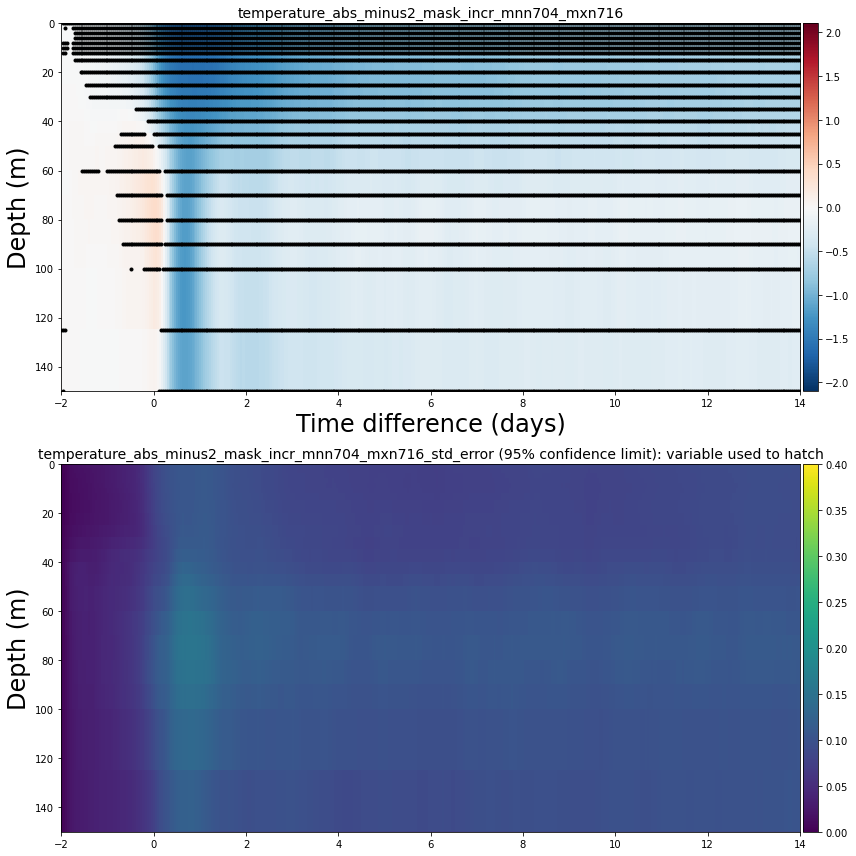

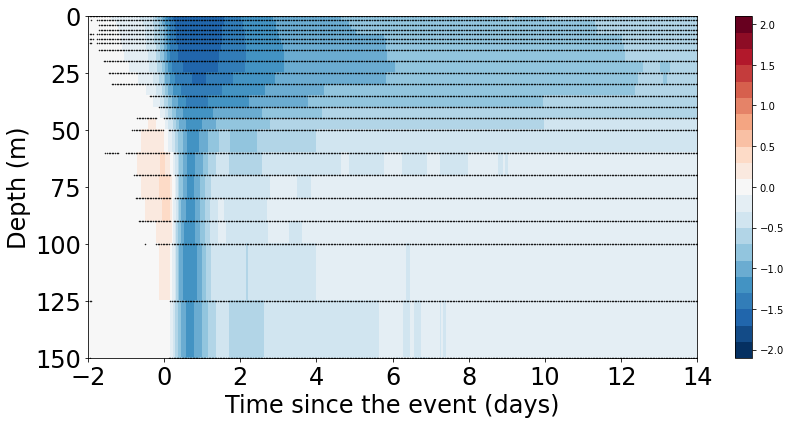

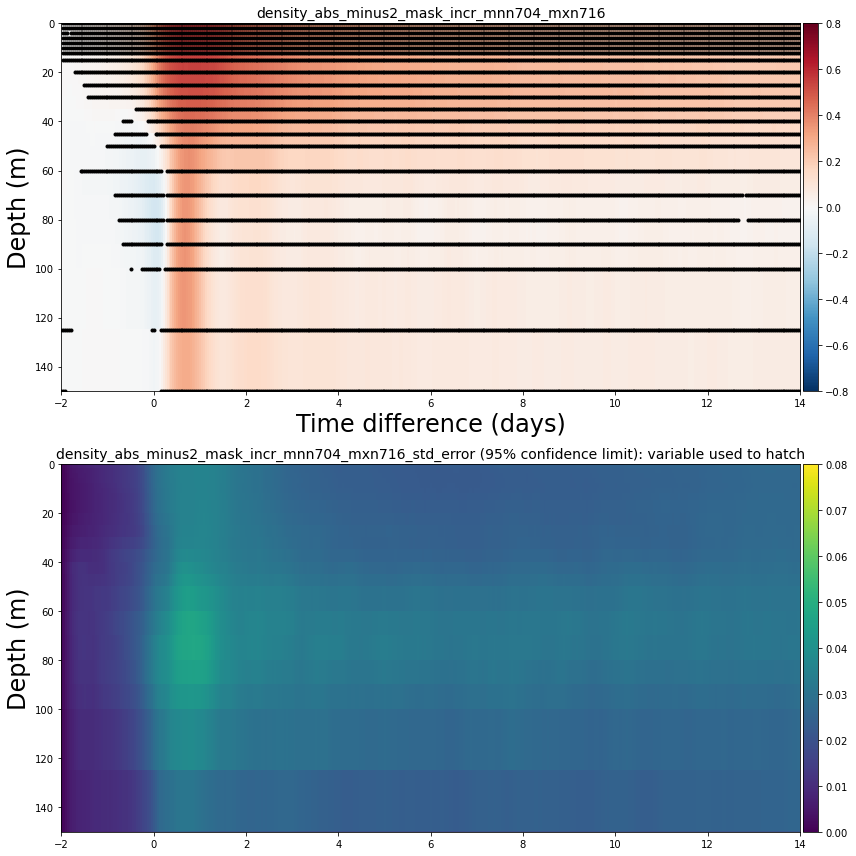

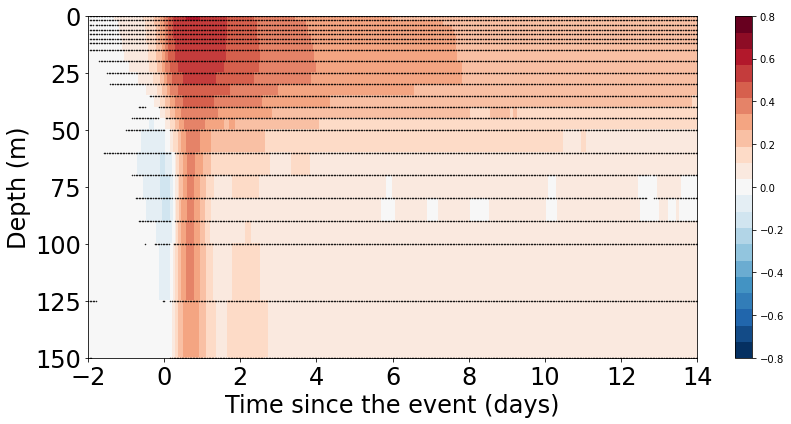

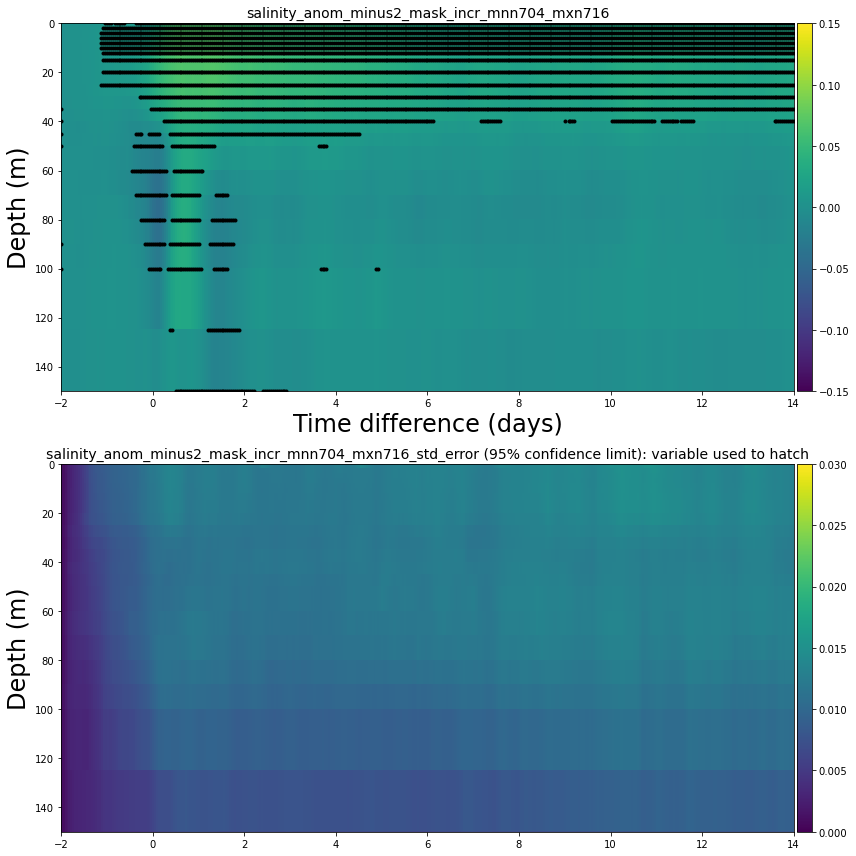

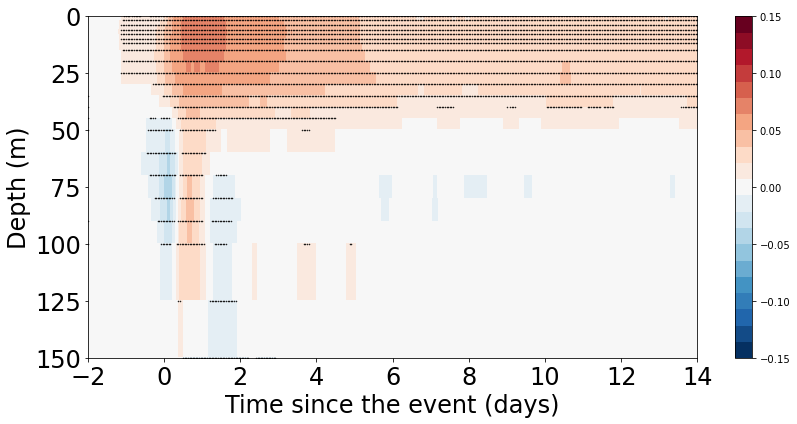

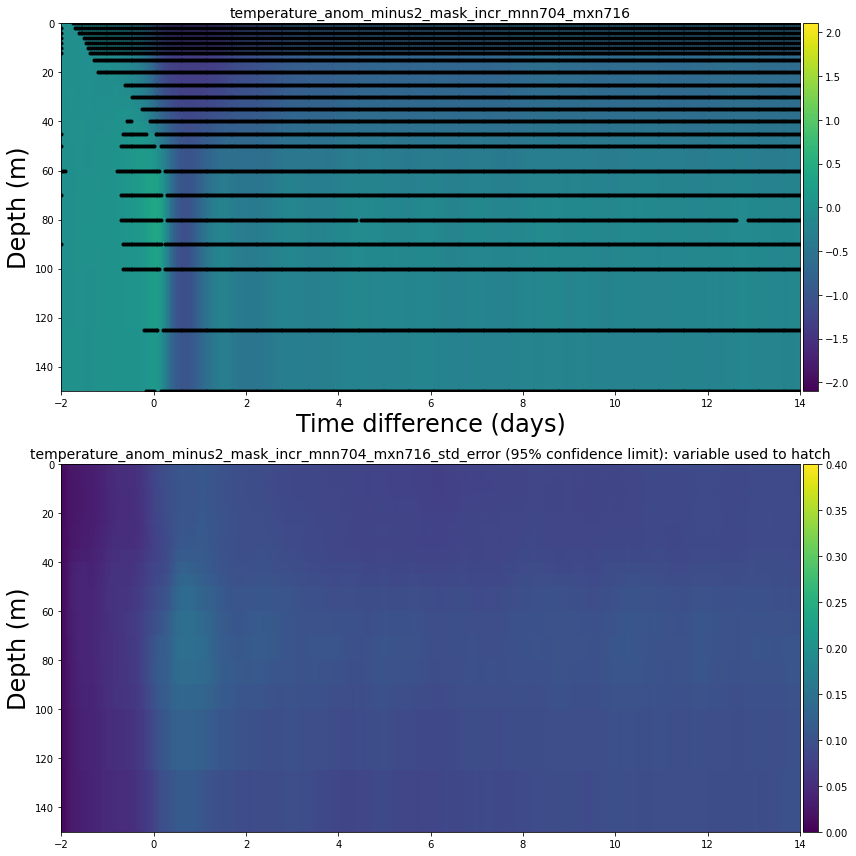

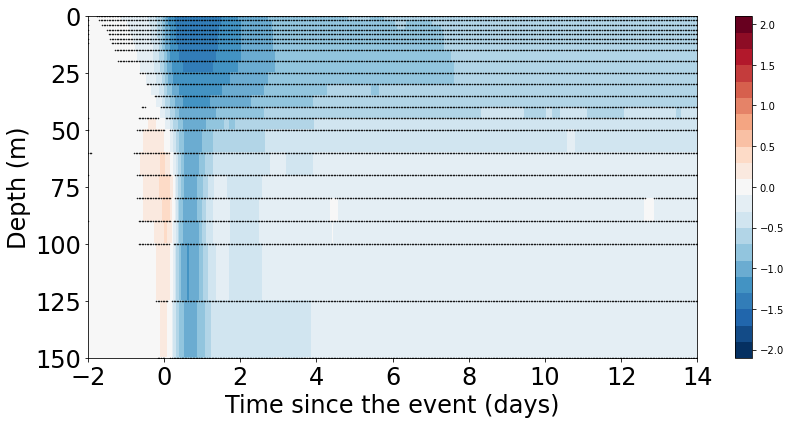

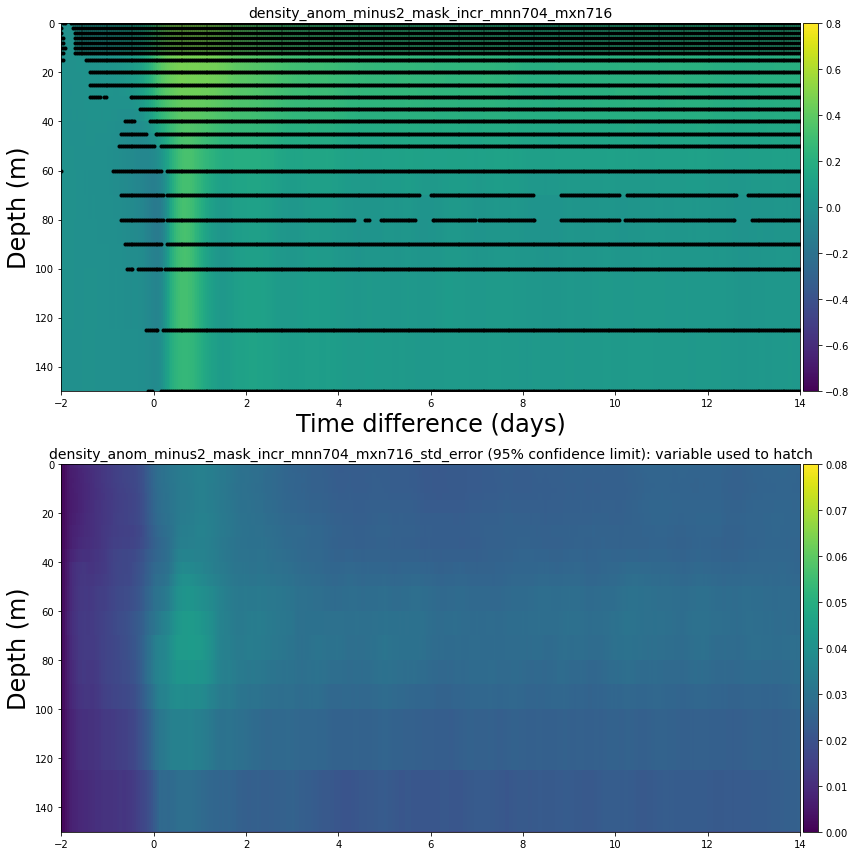

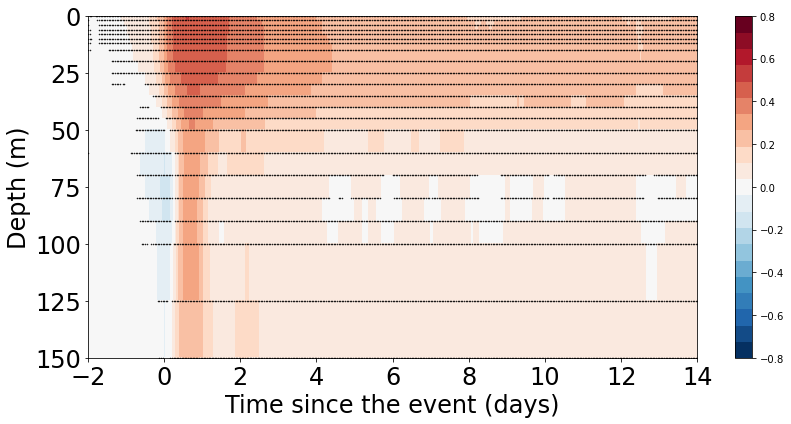

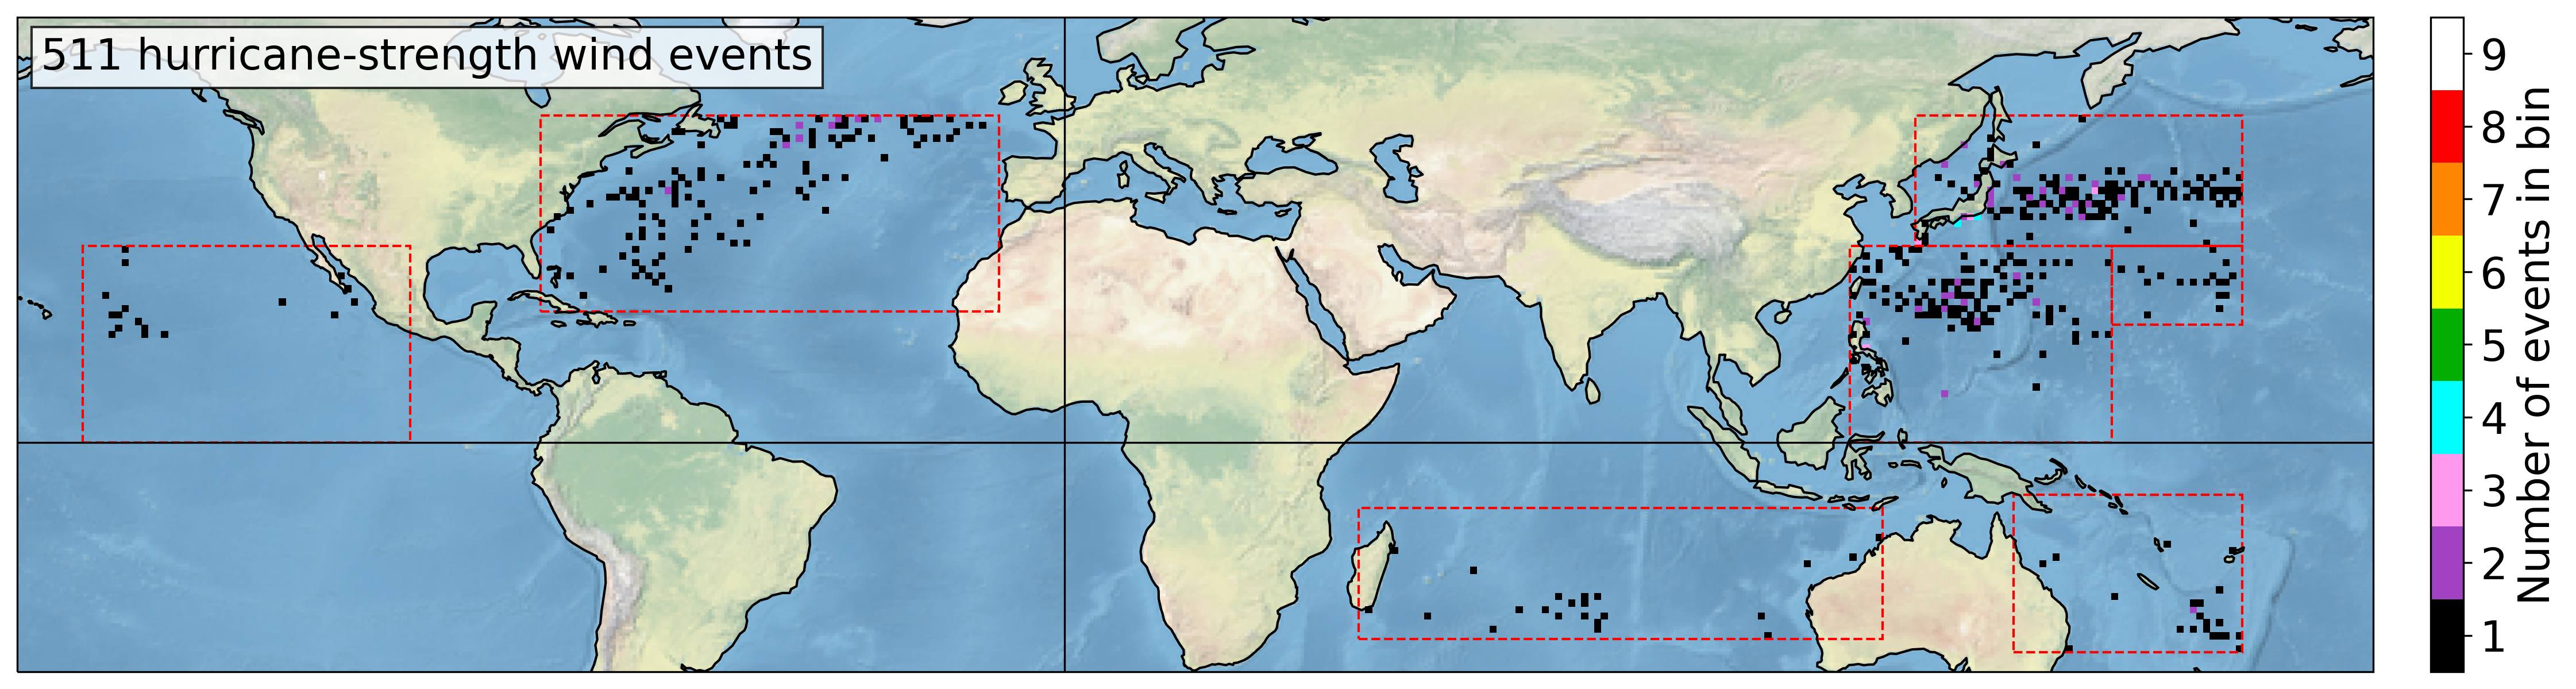

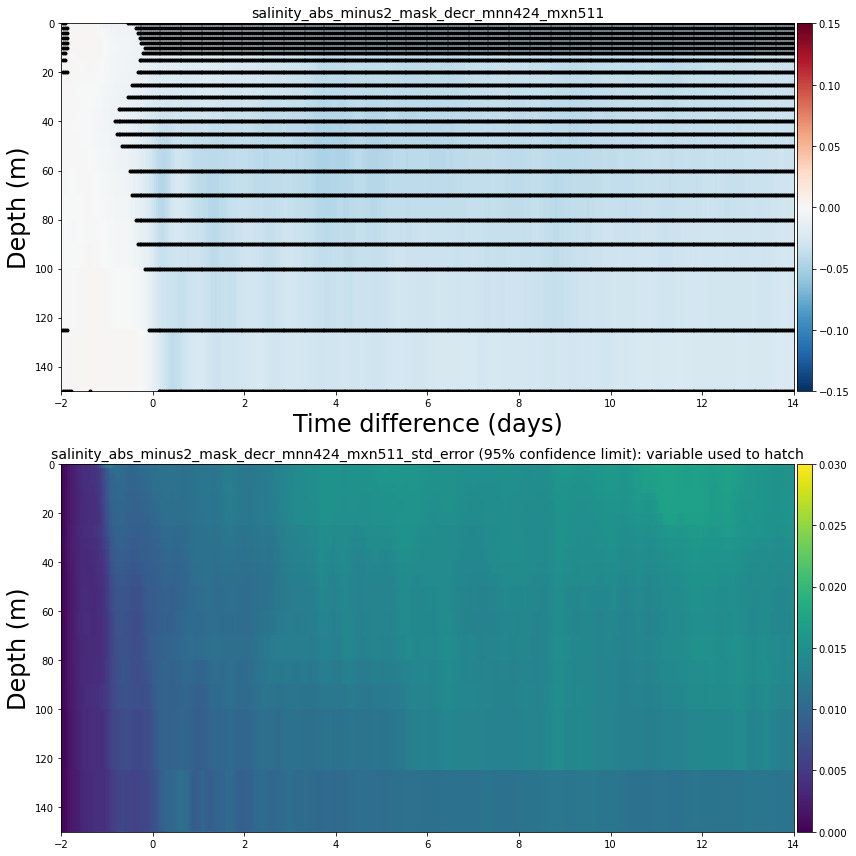

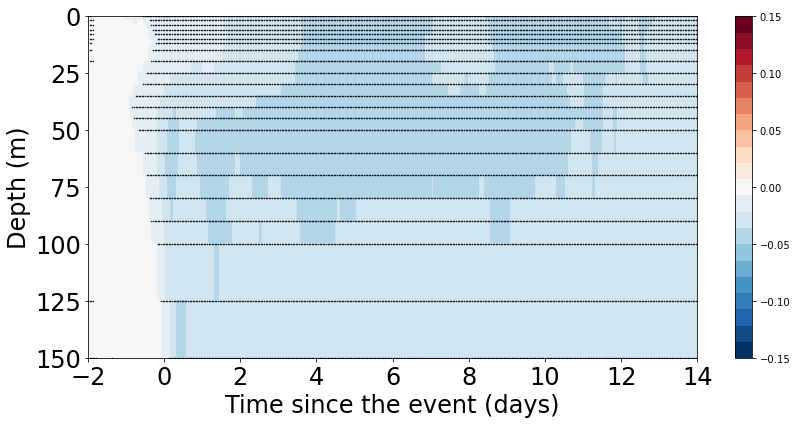

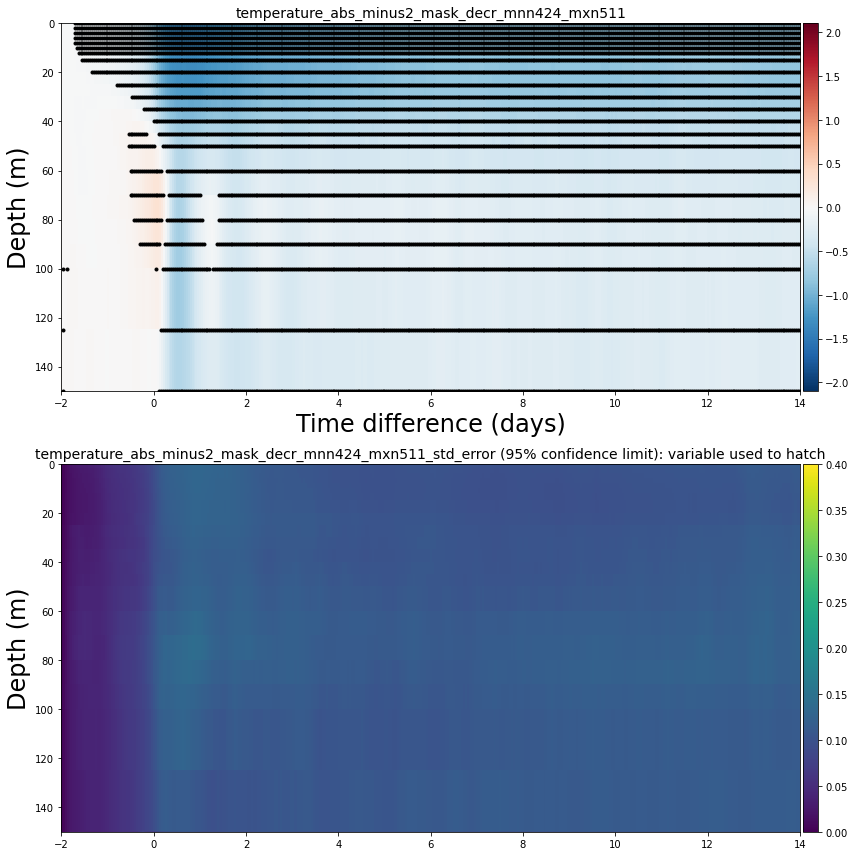

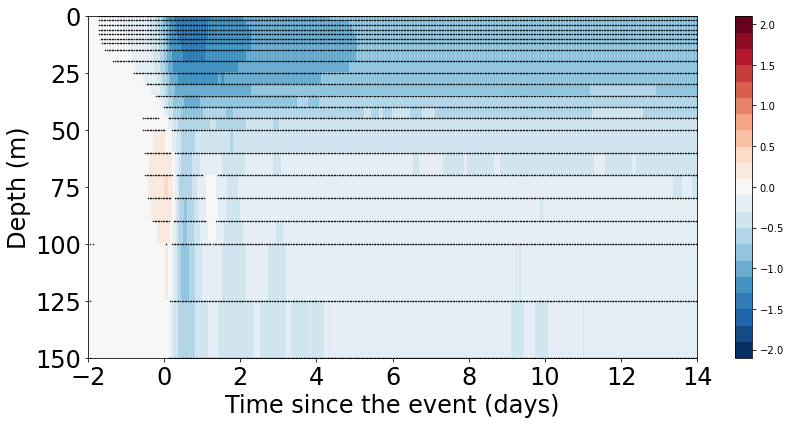

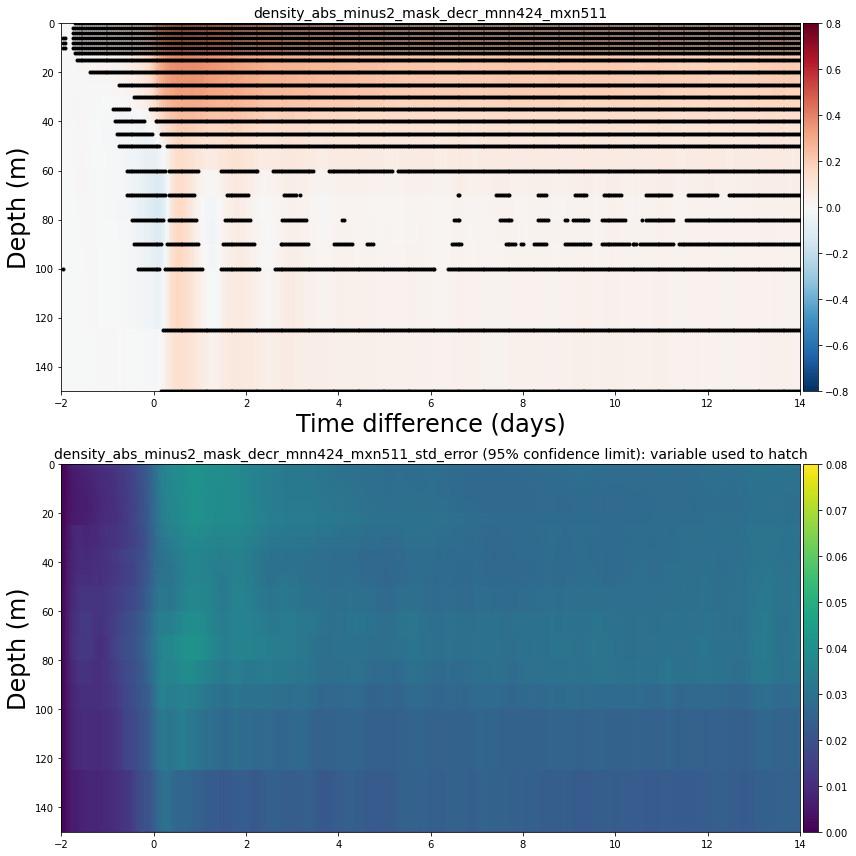

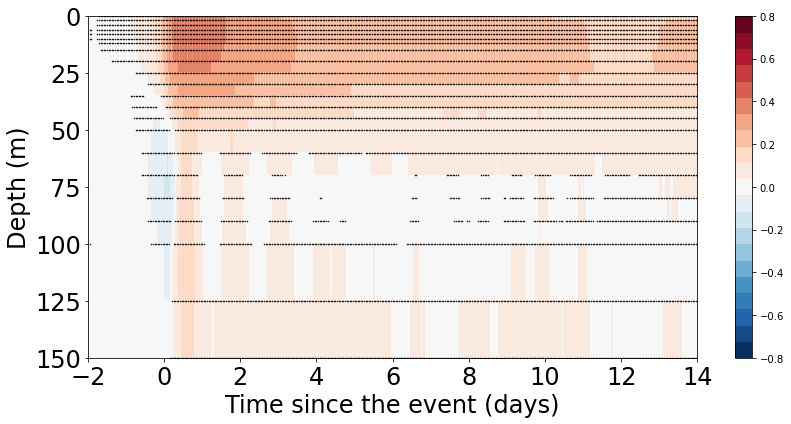

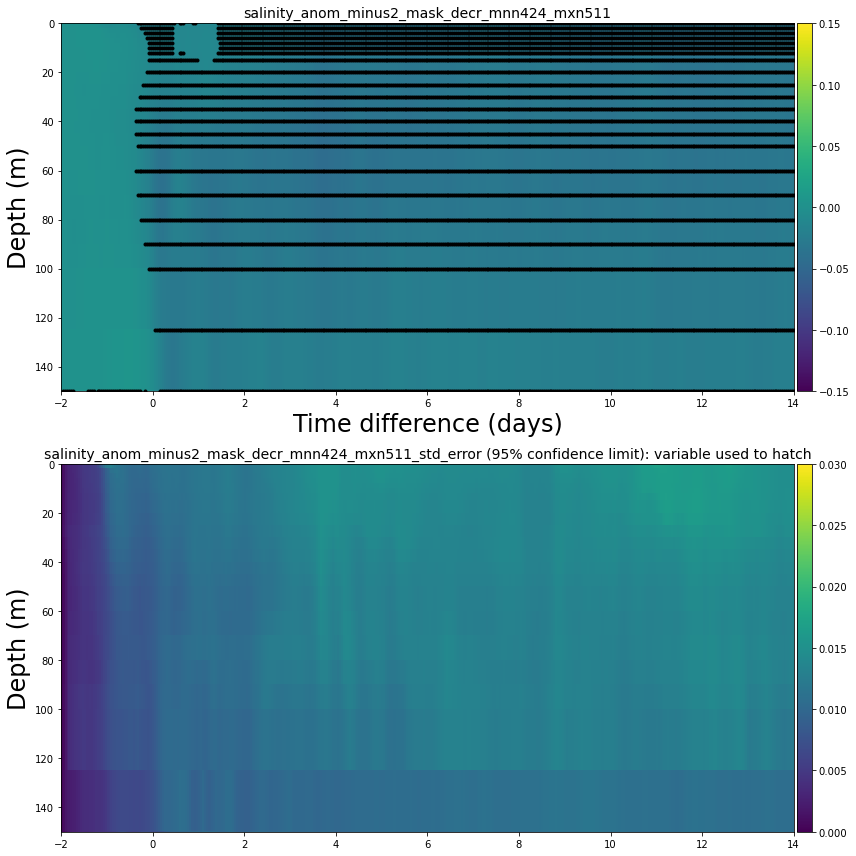

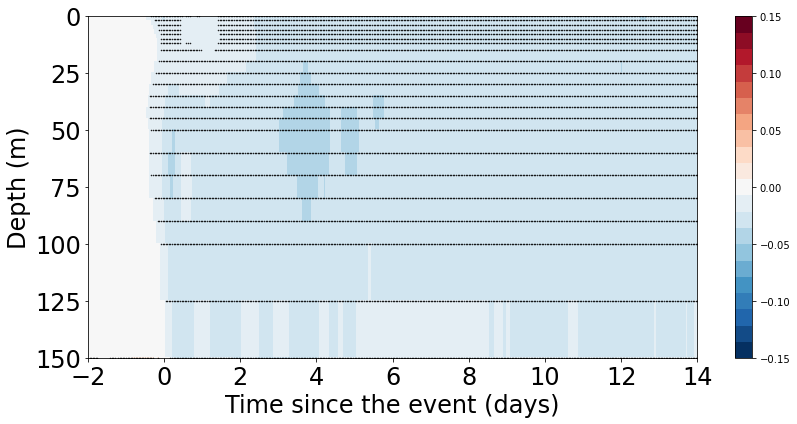

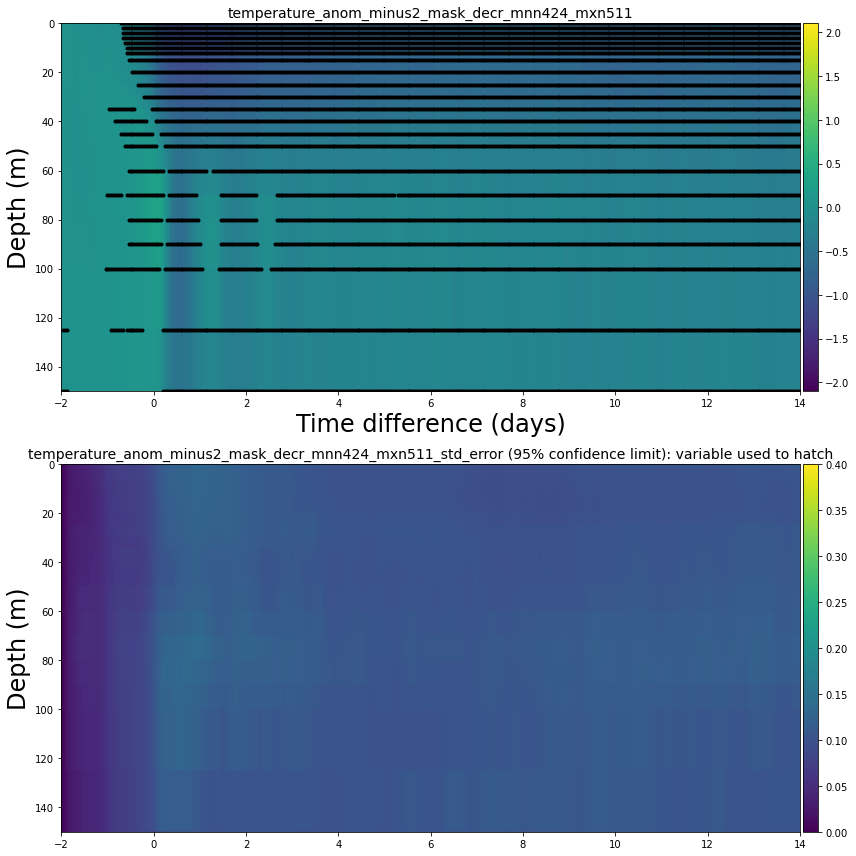

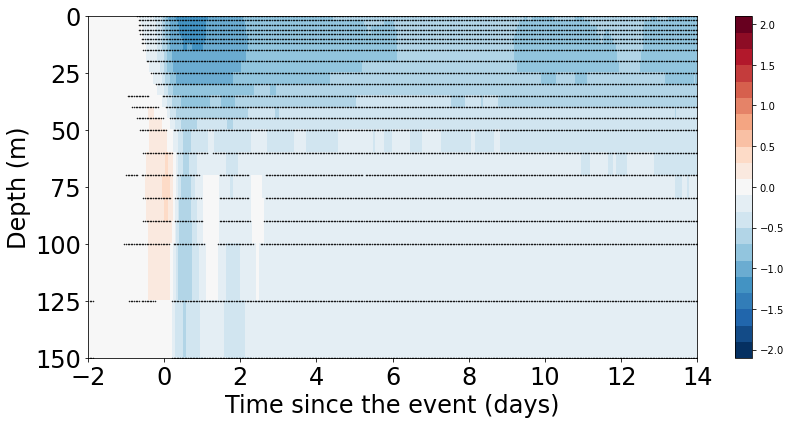

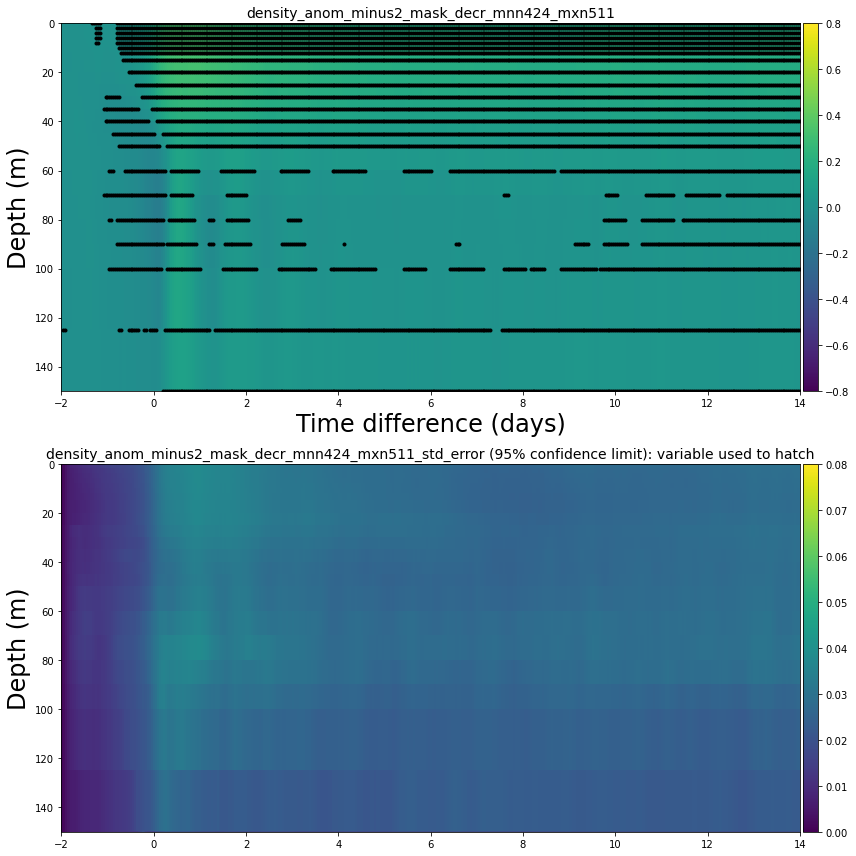

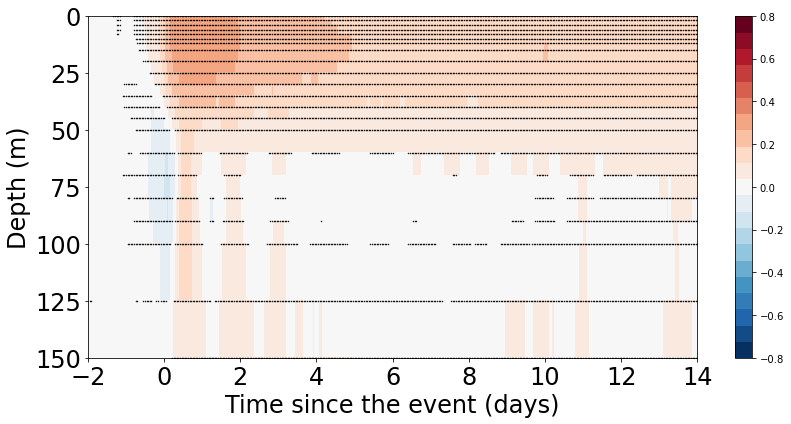

In [13]:
# Make composite plots and 2D maps
for icase in case_list: # masks
    # Make 2D map - need to only create one for each mask type
    function_map_2D_hist(eval(var_list[0] + '_' + type_list[0] + '_' + icase + '_long'), eval(var_list[0] + '_' + type_list[0] + '_' + icase + '_lat'), icase, offset_lon)
    for ihatch in type_hatch_list: # stdev, std error
        if ihatch == '_std_error':
            ihatch_factor = 1.96
            ihatch_factor_tag = ' (95% confidence limit)'
        else:
            ihatch_factor = 1 # change to 2 in the future
            ihatch_factor_tag = ''
            
        for itype in type_list: # abs, abs_minus2, anom
                i = 0
                for ivar in np.arange(0,len(var_list),1): # variables
                    iunit = units_list[i]
                    i = i + 1
                    num = globals()[var_list[ivar] + '_' + itype + '_' + icase + '_num_composite']
                    # Make composite plot
                    function_plots(data = globals()[var_list[ivar] + '_' + itype + '_' + icase], \
                                   data_ihatch = ihatch_factor*globals()[var_list[ivar] + '_' + itype + '_' + icase + ihatch], \
                                   data_tag = var_list[ivar] + '_' + itype + '_' + icase + '_mnn' + str(np.min(num)) + '_mxn' + str(np.max(num)), \
                                   ihatch_tag = ihatch, \
                                   ihatch_tag_confidence_limit = ihatch_factor_tag, \
                                   data_xaxis = time_plot,\
                                   data_yaxis = combined_regions.depth.values,\
                                   data_yaxis_lim = [0, 150], \
                                   data_vmin = set_clim_plots(var_list[ivar], itype)[0], \
                                   data_vmax = set_clim_plots(var_list[ivar], itype)[1], \
                                   std_vmin = set_clim_plots_std(var_list[ivar], itype, ihatch)[0], \
                                   std_vmax = set_clim_plots_std(var_list[ivar], itype, ihatch)[1], \
                                   cmap = set_cmap(itype)) 
                    
                    # SINGLE PANEL plots
                    function_single_panels_plots(data = globals()[var_list[ivar] + '_' + itype + '_' + icase], \
                                   data_ihatch = ihatch_factor*globals()[var_list[ivar] + '_' + itype + '_' + icase + ihatch], \
                                   data_tag = var_list[ivar] + '_' + itype + '_' + icase + '_mnn' + str(np.min(num)) + '_mxn' + str(np.max(num)), \
                                   ihatch_tag = ihatch, \
                                   ihatch_tag_confidence_limit = ihatch_factor_tag, \
                                   data_xaxis = time_plot,\
                                   data_yaxis = combined_regions.depth.values,\
                                   data_yaxis_lim = [0, 150], \
                                   data_vmin = set_clim_plots(var_list[ivar], itype)[0], \
                                   data_vmax = set_clim_plots(var_list[ivar], itype)[1], \
                                   std_vmin = set_clim_plots_std(var_list[ivar], itype, ihatch)[0], \
                                   std_vmax = set_clim_plots_std(var_list[ivar], itype, ihatch)[1], \
                                   cmap = set_cmap(itype),
                                   units = iunit)  
                    

In [14]:
ciao

NameError: name 'ciao' is not defined

In [ ]:
# Calculate differences (incr - decr) and make SINGLE PANEL plots

i = 0
for icase in case_list:
    for ivar in var_list:
        iunit = units_list[i]
        i = i + 1
        for itype in type_list:
            for ihatch in type_hatch_list: # std, std error
                if ihatch == '_std_error':
                    ihatch_factor = 1.96
                    ihatch_factor_tag = ' (95% confidence limit)'
                else:
                    ihatch_factor = 1 # change to 2 in the future
                    ihatch_factor_tag = ''   

                # Increasing vs decreasing for this mask and variable
                bfr_d_incr = eval(ivar + '_' + itype + '_mask_incr')
                bfr_d_decr = eval(ivar + '_' + itype + '_mask_decr')
                bfr_d_incr_ihatch = eval(ivar + '_' + itype + '_mask_incr' + ihatch)
                bfr_d_decr_ihatch = eval(ivar + '_' + itype + '_mask_decr' + ihatch)

                # Calculate differences
                bfr_d_diff = bfr_d_incr - bfr_d_decr
                # Calculate std error of the differences
                bfr_d_diff_ihatch = np.sqrt(np.square(bfr_d_incr_ihatch) + np.square(bfr_d_decr_ihatch))
    #                 bfr_d_diff_ihatch = bfr_d_incr_ihatch + bfr_d_decr_ihatch

                # Make difference plot
                function_single_panels_plots(data = bfr_d_diff, \
                               data_ihatch = ihatch_factor * bfr_d_diff_ihatch, \
                               data_tag = 'diff_' + ivar + '_' + itype + '_' + icase, \
                               ihatch_tag = ihatch, \
                               ihatch_tag_confidence_limit = ihatch_factor_tag, \
                               data_xaxis = time_plot,\
                               data_yaxis = combined_regions.depth.values,\
                               data_yaxis_lim = [0, 150], \
                               data_vmin = set_clim_plots_diff(ivar, itype)[0], \
                               data_vmax = set_clim_plots_diff(ivar, itype)[1], \
                               std_vmin = set_clim_plots_std_diff(ivar, itype, ihatch)[0], \
                               std_vmax = set_clim_plots_std_diff(ivar, itype, ihatch)[1], \
                               cmap = set_cmap(itype),
                               units = iunit)
